# Search Evaluation Notebook

This python notebook will perform a search evaluation 
Prerequisites:
* Golden data set in file ```golden_data.csv```
* Search strategies in python modules located in the ```strategies``` folder

In [ ]:
import requests
from io import StringIO
from dotenv import load_dotenv



# Export the API key to an environment variable
load_dotenv(stream=StringIO(requests.get('http://kubernetes-vm:9000/env').text))
import os, subprocess

openai_api_key =  os.environ.get("LLM_APIKEY") 
url = os.environ.get("LLM_PROXY_URL") 
openai_api_base = f"https://{url}"

os.environ["OPENAI_API_KEY"] = openai_api_key
os.environ["OPENAI_BASE_URL"] = openai_api_base

subprocess.run([
    "deepeval", "set-local-model", 
    "--model-name=eval-gpt-4o", ## needs azure 2024-11-20 +
    f"--base-url={openai_api_base}", 
    f"--api-key={openai_api_key}"
    f""])

# # ## Uncomment the following lines if you want to use .env file to control settings
# load_dotenv()   


True

In [2]:
### What files to work with
GOLDEN_DATA_CSV = "golden_data.csv"
STRATEGIES_FOLDER = "strategies"
SEARCH_OUTPUT_JSON = "results_search_evaluation.json"
DEEPEVAL_OUTPUT_JSON = "results_deepeval_results.json"

In [3]:
## Run the Evaluation

from utility.util_es import get_es
from utility.util_vis_result import vis_search_eval_json, vis_deep_eval_correct_tests
from evaluate import run_search_evaluation, load_golden_data, load_strategies, output_search_eval_results

# https://www.elastic.co/guide/en/elasticsearch/reference/current/search-rank-eval.html
print("### Starting evaluation using Elasticsearch _rank_eval API")

# 1. Connect to Elasticsearch
es = get_es()
print(f"\tConnected to Elasticsearch version: {es.info()['version']['number']}")

# 2. Load the golden data set
golden_data = load_golden_data(GOLDEN_DATA_CSV)
print(f"\tIdentified {len(golden_data)} golden data entry(ies) to use for search evaluation")

# 3. Load strategies from the strategies folder
strategy_modules = load_strategies(STRATEGIES_FOLDER)  
print(f"\tIdentified {len(strategy_modules)} strategy(ies) to evaluate")

# 4. Evaluate each strategy
results = run_search_evaluation(es, golden_data, strategy_modules)

# 5. Output the evaluation results
output_search_eval_results(SEARCH_OUTPUT_JSON, results, golden_data, strategy_modules)



Using ES with configured Host and API key ...
### Starting evaluation using Elasticsearch _rank_eval API
	Connected to Elasticsearch version: 8.17.0
	Identified 18 golden data entry(ies) to use for search evaluation
	Identified 7 strategy(ies) to evaluate
### SEARCH RANK EVAL
	Starting strategy: 1_default_bm25
	Starting strategy: 2_bm25_boosted
	Starting strategy: 3_bm25_boosted_synonym
	Starting strategy: 4_e5
	Starting strategy: 5_e5_hybrid
	Starting strategy: 6_e5_hybrid_qt
	Starting strategy: 7_e5_reranker
### Evaluation complete. 
	Results written to  results_search_evaluation.json


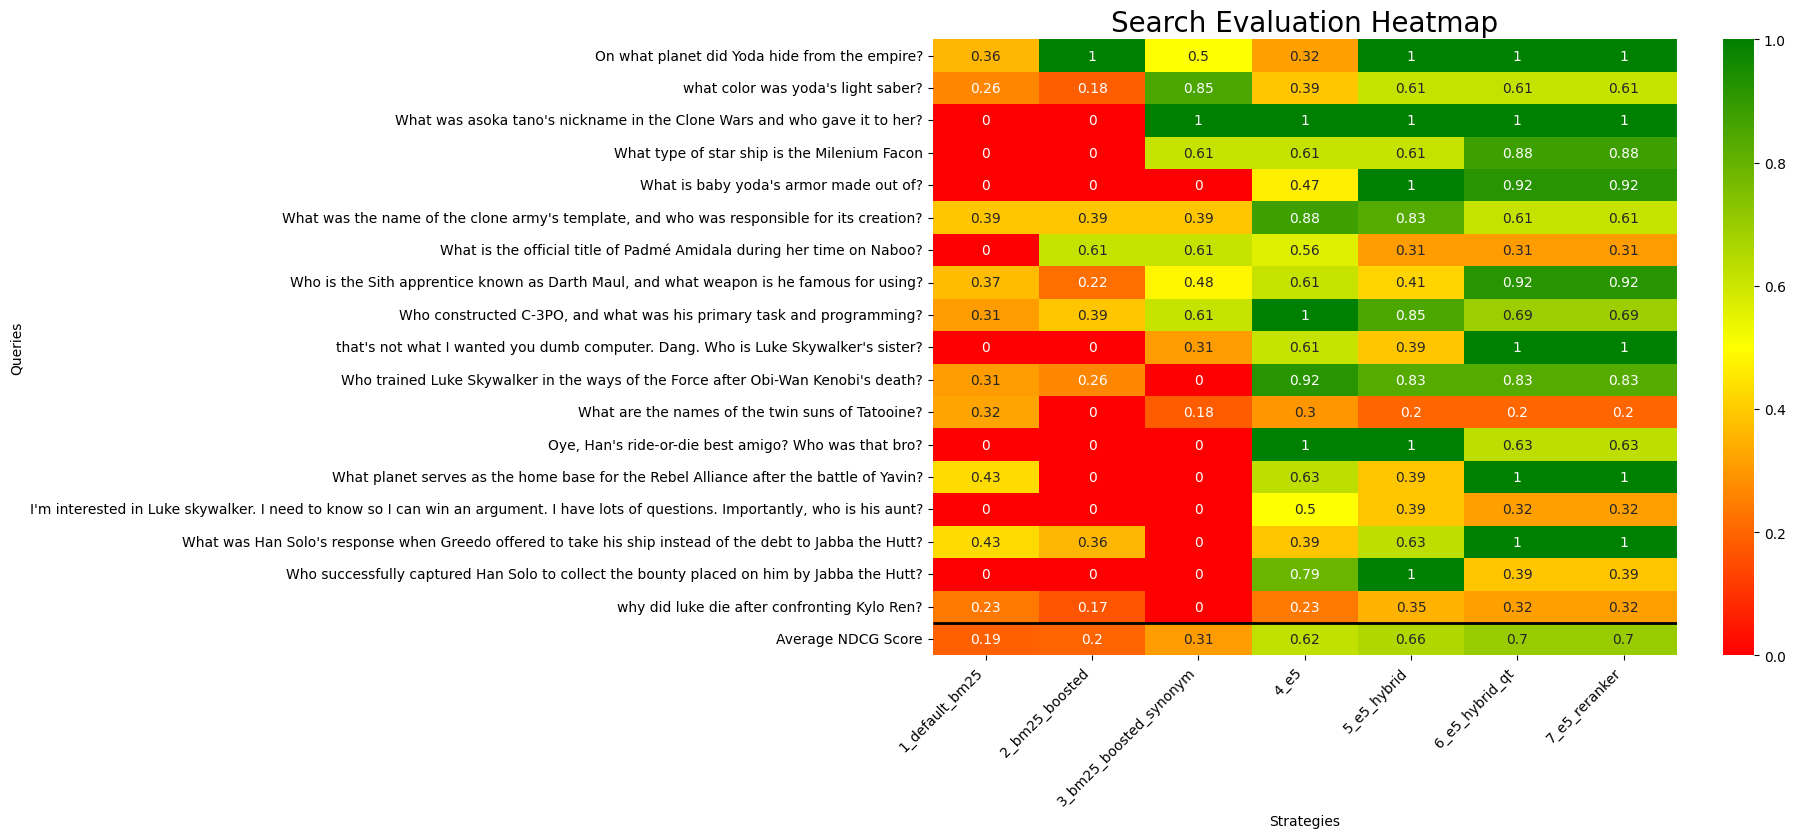

In [4]:
## Visualize the Results of the Evaluation
# 6. Visualize
vis_search_eval_json(SEARCH_OUTPUT_JSON)

In [5]:
from evaluate import run_deepeval, output_deepeval_results

import json

# startegies to Evauate
# include_strategy_names = ["3b_e5_hybrid", "3b_e5_hybrid_qt"]


## Deep Eval Evaluation
print("### DEEP EVAL")
es = get_es()

rag_system_prompt = """
Instructions:

- You are an assistant for question-answering tasks.
- Answer questions truthfully and factually using only the context presented.
- Do not jump to conclusions or make assumptions.
- If the answer is not present in the provided context, just say that you don't know rather than making up an answer or using your own knowledge from outside the prompt.
- You must always cite the document where the answer was extracted using inline academic citation style [], using the position or multiple positions. Example:  [1][3].
- Use markdown format for code examples or bulleted lists.
- You are correct, factual, precise, and reliable.


Context:
{context}
"""

## Search Top 6 documents, with 3 inner hits per doc, send a max of 9 citations to the LLM for RAG
deepEvalScores = run_deepeval(es, strategy_modules, golden_data, rag_system_prompt,6, 3, 9)


## save the scores to disk
output_deepeval_results(DEEPEVAL_OUTPUT_JSON, deepEvalScores)
print(f"\nDeepEval scores saved to {DEEPEVAL_OUTPUT_JSON}")





### DEEP EVAL
Starting strategy: 1_default_bm25
Event loop is already running. Applying nest_asyncio patch to allow async execution...


Evaluating 18 test case(s) in parallel: |██████████|100% (18/18) [Time Taken: 00:00, 32.09test case/s]


Starting strategy: 2_bm25_boosted
Event loop is already running. Applying nest_asyncio patch to allow async execution...


Evaluating 18 test case(s) in parallel: |██████████|100% (18/18) [Time Taken: 00:00, 28.48test case/s]


Starting strategy: 3_bm25_boosted_synonym
	RAG answer: The context provided does not contain information about why Luke Skywalker died after confronting Kylo Ren. Therefore, I don't know the answer to your question based on the given context.
Event loop is already running. Applying nest_asyncio patch to allow async execution...


Evaluating 18 test case(s) in parallel: |██████████|100% (18/18) [Time Taken: 00:07,  2.38test case/s]


Starting strategy: 4_e5
Event loop is already running. Applying nest_asyncio patch to allow async execution...


Evaluating 18 test case(s) in parallel: |██████████|100% (18/18) [Time Taken: 00:05,  3.54test case/s]


Starting strategy: 5_e5_hybrid
Event loop is already running. Applying nest_asyncio patch to allow async execution...


Evaluating 18 test case(s) in parallel: |██████████|100% (18/18) [Time Taken: 00:00, 23.71test case/s]


Starting strategy: 6_e5_hybrid_qt
	RAG answer: Darth Maul is a Force-sensitive Dathomirian Zabrak male who was known as the apprentice of Darth Sidious. He was a formidable warrior strong with the dark side and possessed deadly skills in lightsaber combat. Maul was trained to hate the Jedi Knights and was involved in the Sith's plans to exact revenge on their ancient foes. He is famous for using a red double-bladed lightsaber, which he created himself based on a design found in Darth Sidious' Sith holocron [1][7].
	RAG answer: C-3PO was constructed by Anakin Skywalker, a human slave who lived in Mos Espa, a city on the Outer Rim world of Tatooine. His primary task and programming were designed to interact with organics, focusing on etiquette and protocol. C-3PO was fluent in over six million forms of communication and developed a fussy and worry-prone personality throughout his many decades of operation [4][7].
	RAG answer: After the Battle of Yavin, the Rebel Alliance established thei

Evaluating 18 test case(s) in parallel: |██████████|100% (18/18) [Time Taken: 00:05,  3.07test case/s]


Starting strategy: 7_e5_reranker
	RAG answer: Darth Maul, originally known as Maul, was a Force-sensitive Dathomirian Zabrak male who became a Sith apprentice under Darth Sidious. He was known for his formidable skills in lightsaber combat and his strong connection to the dark side of the Force. Maul was born in 54 BBY and was the son of Mother Talzin, leader of the Nightsisters of Dathomir. He had two siblings, Savage Opress and Feral. Maul was taken as an apprentice by Sidious while still a child and was trained to hate the Jedi Knights and to exact revenge on them [1][2].

Darth Maul is famous for using a red double-bladed lightsaber, which he created himself. This saberstaff consisted of two lightsabers fused together, allowing the blades to extend in a single line. Each blade could be ignited separately, and the design was based on ancient plans found in a Sith holocron owned by Darth Sidious [3][6].
	RAG answer: C-3PO was constructed by Anakin Skywalker from spare parts in the ci

Evaluating 18 test case(s) in parallel: |██████████|100% (18/18) [Time Taken: 00:08,  2.08test case/s]


DeepEval scores saved to results_deepeval_results.json


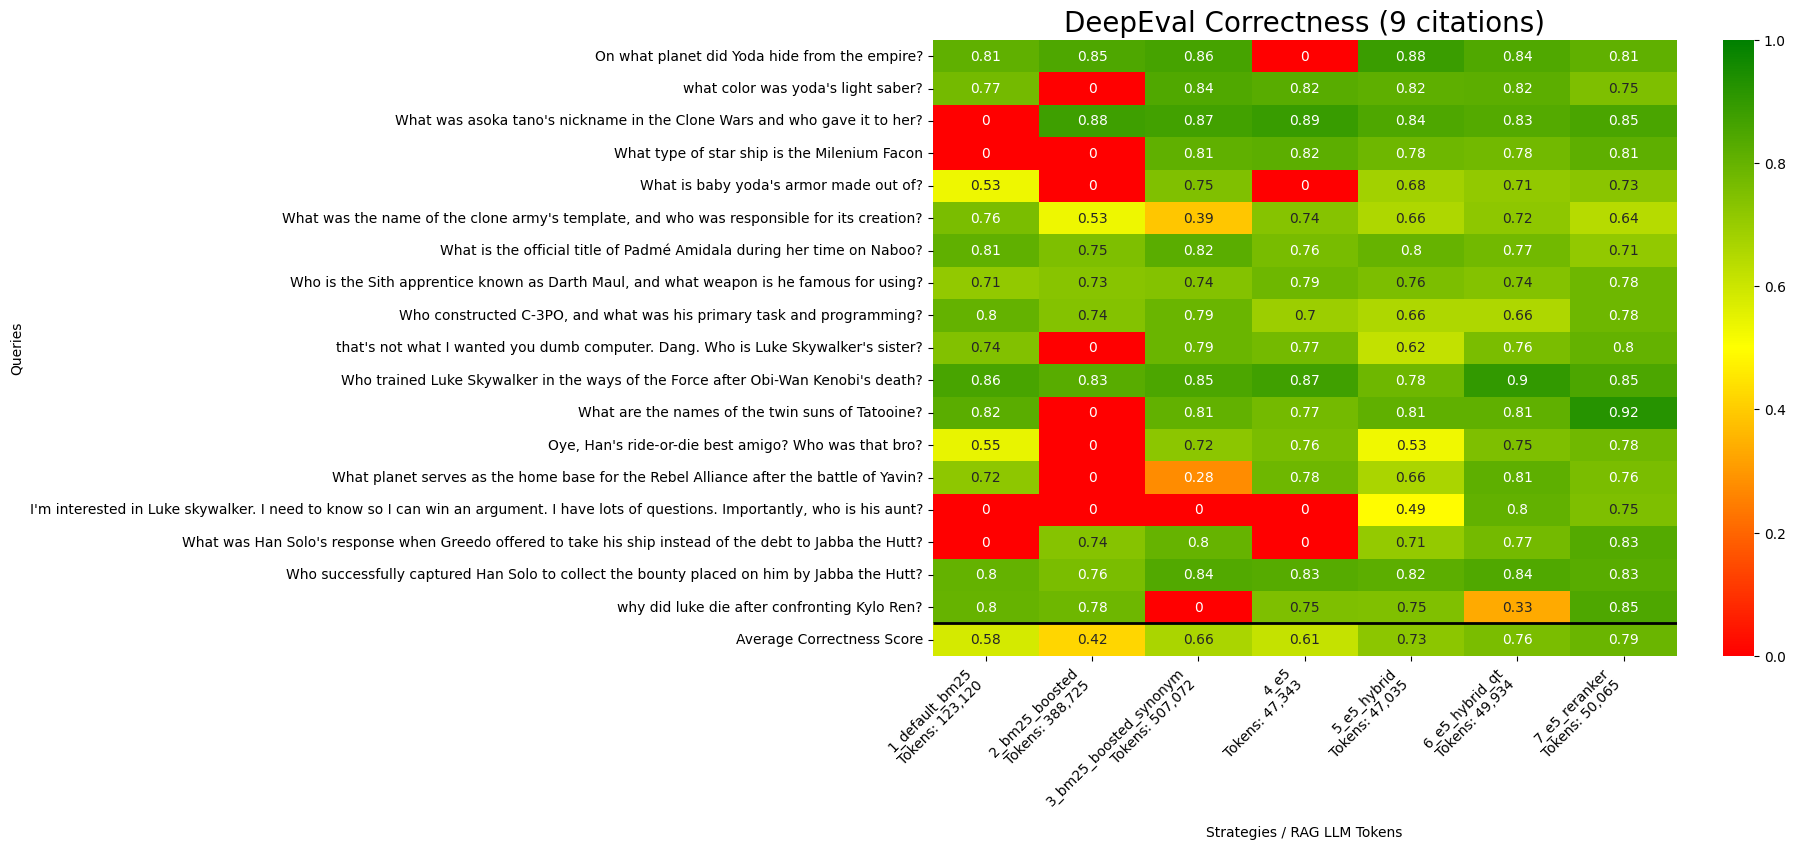

In [6]:
# 6. Visualize
vis_deep_eval_correct_tests(DEEPEVAL_OUTPUT_JSON, "DeepEval Correctness (9 citations)")

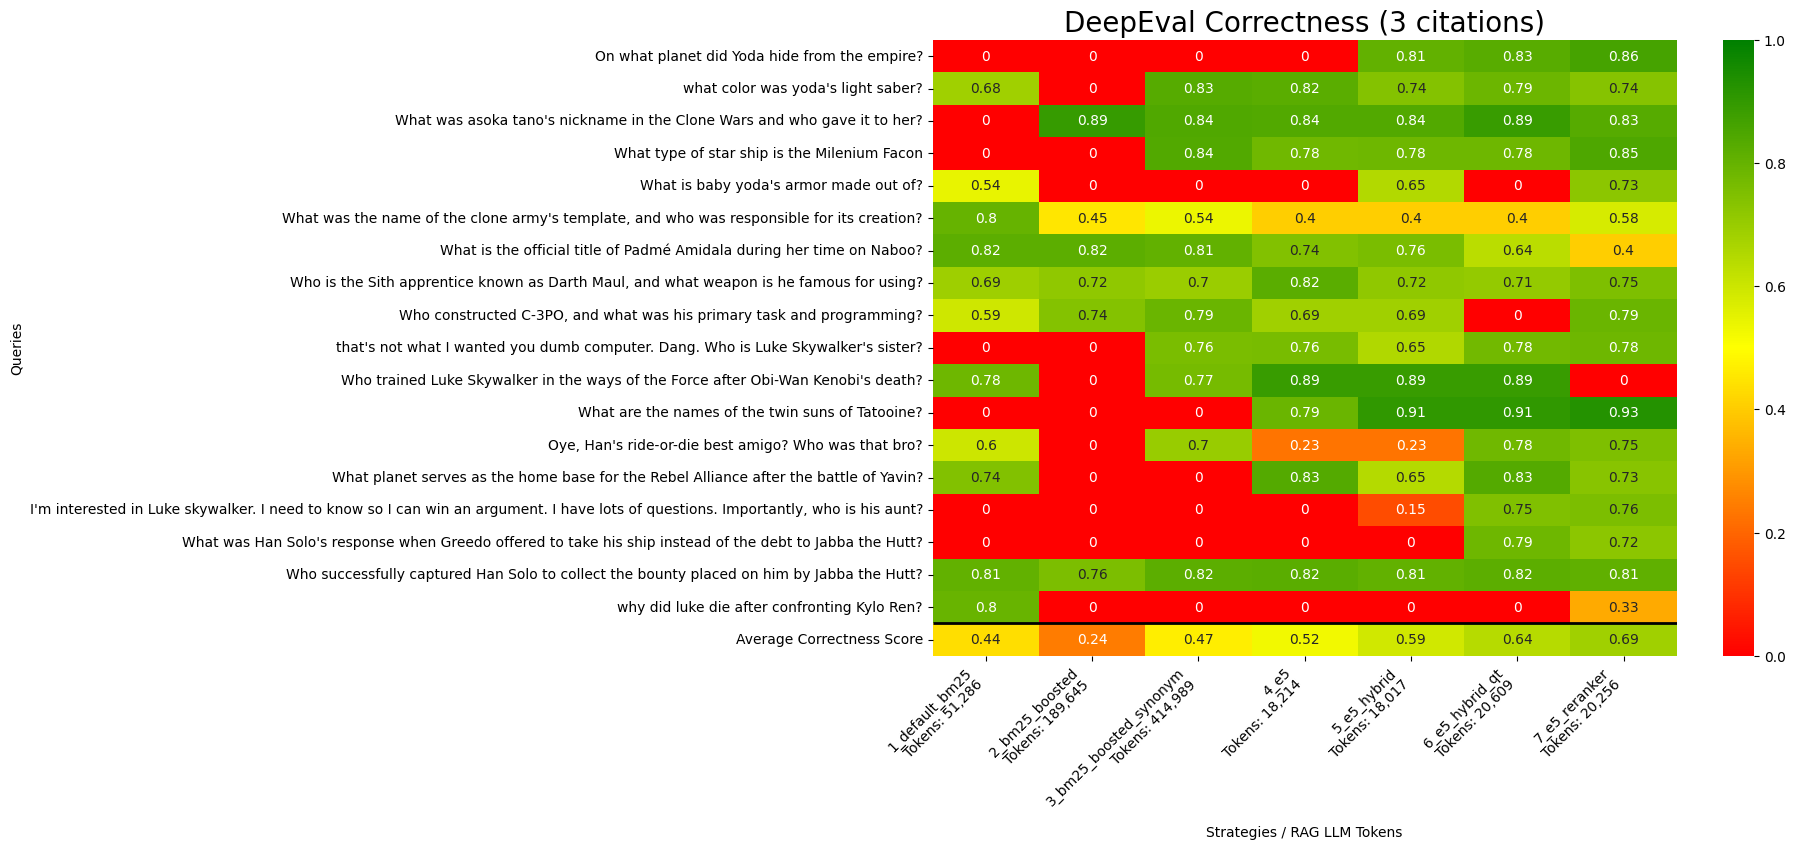

In [7]:
## We'll uncomment this in a later Exercise
## Here's an alternate RAG setup sending 1/3 the tokens to the LLM to save inferences costs
## We should see rescore really shine here

## Search Top 6 documents, with 3 inner hits per doc, send a max of 3 citationss to the LLM for RAG
deepEvalScores = run_deepeval(es, strategy_modules, golden_data, rag_system_prompt,6, 3, 3)


## save the scores to disk
output_deepeval_results(f"{DEEPEVAL_OUTPUT_JSON}_2", deepEvalScores)
print(f"\nDeepEval scores saved to {DEEPEVAL_OUTPUT_JSON}_2")

vis_deep_eval_correct_tests(f"{DEEPEVAL_OUTPUT_JSON}_2", "DeepEval Correctness (3 citations)")